# IMPORTAMOS LAS LIBRERIAS QUE VAMOS A UTILIZAR

In [1]:
#Ejecuta esta celda para importar las librerias
import pandas as pd
import numpy as np
import scipy.integrate as integ
import threading

import matplotlib.pyplot as plt
import time

# Introducción de los datos del modelo

In [2]:
#Ejecuta esta celda para introducir los datos

DatosEntrada=pd.read_excel('datos/datostld100.xlsx', sheet_name='Hoja1', header=0, usecols=None, nrows=None)

dfnew=DatosEntrada

E=dfnew.iloc[:,0]         # Energia de Activación (eV).
s=dfnew.iloc[:,1]         # Factor de Frecuencia (s-1).
n=dfnew.iloc[:,2]         # Concentracion de electrones atrapados en las trampas (cm-3).
N=dfnew.iloc[:,3]         # Numero de posiciones acesibles por los electrnes de la BC a la Trampa (cm-3).
A=dfnew.iloc[:,4]         # Coeficiente de Probabilidad de atrapamiento de electrones de a trampa (cm+3·s-1).
Amn_R=dfnew.iloc[0:1,5]   # Coeficiente de probabilidad de recombinacion e-h Radiativa (cm+3·s-1).
Amn_NR=dfnew.iloc[0:1,6]  # Coeficiente de probabilidad de recombinacion e-h No Radiativa (cm+3·s-1).
A_R=dfnew.iloc[0:1,7]     # Coeficiente de Probabilidad de atrapamiento de huecos de la BV al Centro de Recombinacion Radiativo (cm+3·s-1).
A_NR=dfnew.iloc[0:1,8]    # Coeficiente de Probabilidad de atrapamiento de huecos de la BV al Centro de Recombinacion No Radiativo (cm+3·s-1).
M_R=dfnew.iloc[0:1,9]    # Numero de posiciones acesibles huecos de la BV al Centro de Recombinacion Radiativo (cm-3).
M_NR=dfnew.iloc[0:1,10]  # Numero de posiciones acesibles huecos de la BV al Centro de Recombinacion No Radiativo (cm-3).
m_R=dfnew.iloc[0:1,11]   # Concentracion de h atrapados en el centro de recombonacion radiativo (cm-3).
m_NR=dfnew.iloc[0:1,12]  # Concentracion de h atrapados en el centro de recombonacion no radiativo (cm-3).
f=dfnew.iloc[0:1,13]     # Factor de generacion de pares e-h (cm-3·s-1).
n_c=dfnew.iloc[0:1,14]   # Concentración de electrones libres en la banda de conduccion (cm-3).
n_h=dfnew.iloc[0:1,15]   # Concentración de huecos libres en la banda de Valencia (cm-3).


E=E.to_numpy()
s=s.to_numpy()
n=n.to_numpy()
N=N.to_numpy()
A=A.to_numpy()
Amn_R=Amn_R.to_numpy()
Amn_NR=Amn_NR.to_numpy()
A_R=A_R.to_numpy()
A_NR=A_NR.to_numpy()
M_R=M_R.to_numpy()
M_NR=M_NR.to_numpy()
m_R=m_R.to_numpy()
m_NR=m_NR.to_numpy()
f=f.to_numpy()
n_c=n_c.to_numpy()
n_h=n_h.to_numpy()

#Condiciones iniciales
nn=np.array(n_c[0])
for i in range(len(n)):
    nn=np.append(nn,n[i])
nn=np.append(nn,m_R[0])
nn=np.append(nn,m_NR[0])
nn=np.append(nn,n_h[0])

#Constante de boltzman
kb=0.00008617333262


# Definición de las funciones del modelo

In [3]:
#Ejecuta esta celda para definir las funciones del modelo

Nsat=np.ones(len(N))*10**11 #aquí definimos el N de saturación y corregimos el numero de trampas en 4 a parte de definir las funciones de N
N[3]=N[3]/2
N[4]=N[4]/4

Nsat[1]=Nsat[1]*10
Nsat[3]=Nsat[3]*0.3
Nsat[4]=Nsat[4]*0.5

mu=2.7

def Ng(t,i):        #En esta función simulamos la creación de trampas durante la irradiación
        Ngg=[]
        C=1
        Ngg=N[i]*np.exp(np.log10(Nsat[i]/N[i])*(1-np.exp(-C*t)))
        return Ngg    

def Nee(E,i,T):           #Esta es la distribución de Fermi-Dirac que utilizaremos en la irradiación
        Ngg=[]
        Ngg=N[i]/(1+np.exp((E-mu)/(kb*T)))
        return Ngg   

def NFCT(E,i,T,t):        #Aquí simulamos la creación de trampas durante la irradiación, utilizando también la distribución de Fermi-Dirac
        NNN=Nee(E,i,T)*Ng(t,i)/N[i]
        return NNN
NN=N
def Ne(E,i,T):            #Aquí definimos la distribución de Fermi-Dirac para utilizarla utilizando el numero de trampas disponibles tras la irradiación
        Ngg=[]
        Ngg=NN[i]/(1+np.exp((E-mu)/(kb*T)))
        return Ngg 




def TLIN(t,u):         #Con esta función simulamos la irradiación añadiendo la creación de trampas, utilizando la función de arrenius para la probabilidad
        Tamb=297.15
        kb=0.00008617333262
        dx=np.zeros(len(nn))
        Constante_A=0.0
        for i in range(1,len(dx)-3):
                dx[i]=-u[i]*(s[i-1]*np.exp(-E[i-1]/(kb*Tamb)))+A[i-1]*(Ng(t,i-1)-u[i])*u[0]
                Constante_A+=dx[i]
        dx[0]=f-Constante_A-u[0]*(u[-3]*Amn_R[0]+u[-2]*Amn_NR[0])
        dx[-3]=A_R[0]*(M_R[0]-u[-3])*u[-1]-u[0]*(u[-3]*Amn_R[0])
        dx[-2]=A_NR[0]*(M_NR[0]-u[-2])*u[-1]-u[0]*(u[-2]*Amn_NR[0])
        dx[-1]=f-u[-1]*(+A_R[0]*(M_R[0]-u[-3])+A_NR[0]*(M_NR[0]-u[-2]))
        return np.array(dx,dtype=object)

def TLINE(t,u):       #Aquí simulamos la irradiación añadiendo la creación de trampas, utilizando la distribución de F-D      
        Tamb=297.15
        kb=0.00008617333262
        dx=np.zeros(len(nn))
        Constante_A=0.0
        for i in range(1,len(dx)-3):
                dx[i]=-u[i]*(s[i-1]*np.exp(-E[i-1]/(kb*Tamb)))+A[i-1]*(NFCT(E[i-1],i-1,Tamb,t)-u[i])*u[0]
                Constante_A+=dx[i]
        dx[0]=f-Constante_A-u[0]*(u[-3]*Amn_R[0]+u[-2]*Amn_NR[0])
        dx[-3]=A_R[0]*(M_R[0]-u[-3])*u[-1]-u[0]*(u[-3]*Amn_R[0])
        dx[-2]=A_NR[0]*(M_NR[0]-u[-2])*u[-1]-u[0]*(u[-2]*Amn_NR[0])
        dx[-1]=f-u[-1]*(+A_R[0]*(M_R[0]-u[-3])+A_NR[0]*(M_NR[0]-u[-2]))
        return np.array(dx,dtype=object)

Tamb=273.15
def TLRNE(t,u):    #Simulamos la relajación tras la irradiación (reduciendo la fuente de radiación en un factor 1000) partiendo de las concentraciones y 
                        #el número de trampas tras la irradiación añadiendo la creación de trampas, utilizando la distribución de F-D  Nota: revisar que esté bien implementado
        Tamb=273.15 
        kb=0.00008617333262
        dx=np.zeros(len(nn))
        Constante_A=0.0
        for i in range(1,len(dx)-3):
                dx[i]=-u[i]*(s[i-1]*np.exp(-E[i-1]/(kb*Tamb)))+A[i-1]*(NN[i-1]-u[i])*u[0]
                Constante_A+=dx[i]
        dx[0]=f/1000-Constante_A-u[0]*(u[-3]*Amn_R[0]+u[-2]*Amn_NR[0])
        dx[-3]=A_R[0]*(M_R[0]-u[-3])*u[-1]-u[0]*(u[-3]*Amn_R[0])
        dx[-2]=A_NR[0]*(M_NR[0]-u[-2])*u[-1]-u[0]*(u[-2]*Amn_NR[0])
        dx[-1]=f/1000-u[-1]*(+A_R[0]*(M_R[0]-u[-3])+A_NR[0]*(M_NR[0]-u[-2]))
        return np.array(dx,dtype=object)

def TLI(t,u):            #Simulación de la irradiación sin tener en cuenta la creación de trampas usando la ley de arrenius
        Tamb=297.15
        kb=0.00008617333262
        dx=np.zeros(len(nn))
        Constante_A=0.0
        for i in range(1,len(dx)-3):
                dx[i]=-u[i]*(s[i-1]*np.exp(-E[i-1]/(kb*Tamb)))+A[i-1]*(N[i-1]-u[i])*u[0]
                Constante_A+=dx[i]
        dx[0]=f-Constante_A-u[0]*(u[-3]*Amn_R[0]+u[-2]*Amn_NR[0])
        dx[-3]=A_R[0]*(M_R[0]-u[-3])*u[-1]-u[0]*(u[-3]*Amn_R[0])
        dx[-2]=A_NR[0]*(M_NR[0]-u[-2])*u[-1]-u[0]*(u[-2]*Amn_NR[0])
        dx[-1]=f-u[-1]*(+A_R[0]*(M_R[0]-u[-3])+A_NR[0]*(M_NR[0]-u[-2]))
        return np.array(dx,dtype=object)


def TLR(t,u):        #Simulación de la relajación de la función anterior
        Tamb=297.15
        kb=0.00008617333262
        dx=np.zeros(len(nn))
        Constante_A=0.0
        for i in range(1,len(dx)-3):
                dx[i]=-u[i]*(s[i-1]*np.exp(-E[i-1]/(kb*Tamb)))+A[i-1]*(N[i-1]-u[i])*u[0]
                Constante_A+=dx[i]
        dx[0]=f/1000-Constante_A-u[0]*(u[-3]*Amn_R[0]+u[-2]*Amn_NR[0])
        dx[-3]=A_R[0]*(M_R[0]-u[-3])*u[-1]-u[0]*(u[-3]*Amn_R[0])
        dx[-2]=A_NR[0]*(M_NR[0]-u[-2])*u[-1]-u[0]*(u[-2]*Amn_NR[0])
        dx[-1]=f/1000-u[-1]*(+A_R[0]*(M_R[0]-u[-3])+A_NR[0]*(M_NR[0]-u[-2]))
        return np.array(dx,dtype=object)

def TLE(t,u,beta):      #Simulación del calentamiento
        Tamb=297.15+float(t)*beta
        kb=0.00008617333262
        dx=np.zeros(len(nn))
        Constante_A=0.0
        for i in range(1,len(dx)-3):
                if u[i]>10:
                        dx[i]=-u[i]*(s[i-1]*np.exp(-E[i-1]/(kb*Tamb)))+A[i-1]*(NN[i-1]-u[i])*u[0]
                        Constante_A+=dx[i]
        dx[0]=f/1000-Constante_A-u[0]*(u[-3]*Amn_R[0]+u[-2]*Amn_NR[0])
        dx[-3]=A_R[0]*(M_R[0]-u[-3])*u[-1]-u[0]*(u[-3]*Amn_R[0])
        dx[-2]=A_NR[0]*(M_NR[0]-u[-2])*u[-1]-u[0]*(u[-2]*Amn_NR[0])
        dx[-1]=f/1000-u[-1]*(+A_R[0]*(M_R[0]-u[-3])+A_NR[0]*(M_NR[0]-u[-2]))
        return np.array(dx,dtype=object)


def TLECT(t,u):                         #Simulación del calentamiento utilizando una curva de temperaturas 
                                                #a elección (CT(t))
        Tamb=CT(t)
        kb=0.00008617333262
        dx=np.zeros(len(nn))
        Constante_A=0.0
        for i in range(1,len(dx)-3):
                if u[i]>10:
                        dx[i]=-u[i]*(s[i-1]*np.exp(-E[i-1]/(kb*Tamb)))+A[i-1]*(NN[i-1]-u[i])*u[0]
                        Constante_A+=dx[i]
        dx[0]=f/1000-Constante_A-u[0]*(u[-3]*Amn_R[0]+u[-2]*Amn_NR[0])
        dx[-3]=A_R[0]*(M_R[0]-u[-3])*u[-1]-u[0]*(u[-3]*Amn_R[0])
        dx[-2]=A_NR[0]*(M_NR[0]-u[-2])*u[-1]-u[0]*(u[-2]*Amn_NR[0])
        dx[-1]=f/1000-u[-1]*(+A_R[0]*(M_R[0]-u[-3])+A_NR[0]*(M_NR[0]-u[-2]))
        return np.array(dx,dtype=object)

def tl(X,T,beta):                      #Calculamos la curva de termoluminiscencia
        Temp=np.zeros(len(T))
        TL=np.zeros(len(T))
        for i in range(len(T)):
                Temp[i]=T[i]*beta+297.15-273.15
                TL[i]=A_R*X[0,i]*X[-3,i]/beta
        return Temp,TL

def tl200(X,T,beta):                    #Guardamos 200 canales de la curva de termoluminiscencia
        Temp,TL=tl(X,T,beta)
        t200=np.linspace(Temp[0],Temp[-1],200)
        tl200=np.interp(t200,Temp,TL)           
        return t200,tl200

# Resolución del modelo

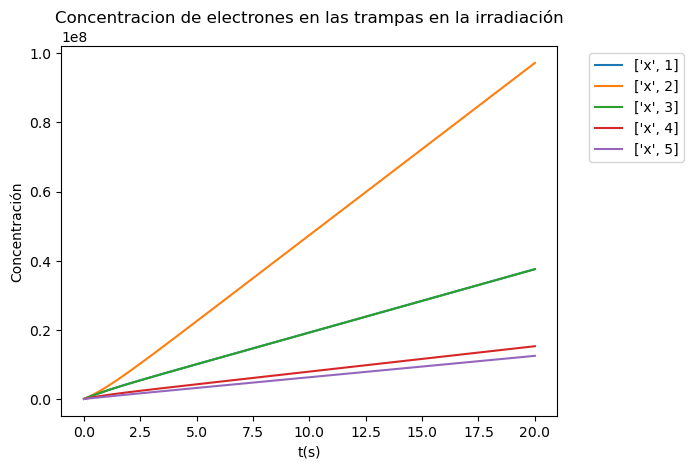

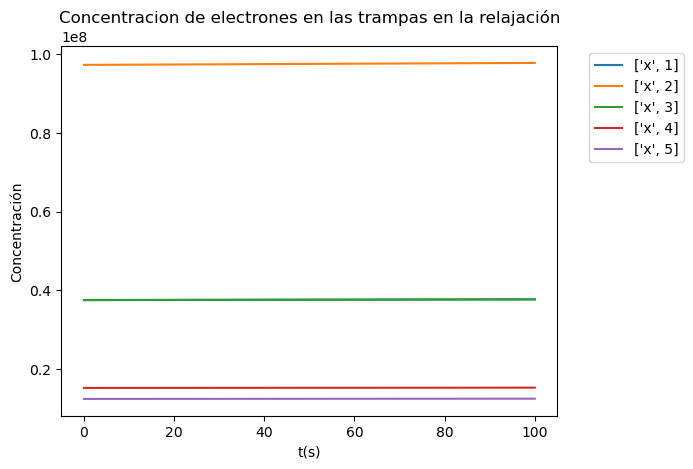

In [8]:
#En esta celda simulamos la irradiación y la relajación


NN=np.zeros(len(N))  #Iniziamos la variable que albergará el nuevo número de trampas
tmax=20                 #tiempo de irradiación
solirrad=integ.solve_ivp(fun=TLINE,t_span=[0,tmax],y0=nn)    #Resolvemos el modelo para la irradiación utilizando 'TLINE'
for i in range(len(N)):
    NN[i]=NFCT(E[i],i,297.15,tmax)       #aquí estamos actualizando el numero de trampas que hay después de crearse para que lo use el resto de funciones
ti=solirrad.t    #Guardamos el tiempo de la solución en ti
xi=solirrad.y    #Guardamos las concentraciones de la solución en xi

#pi=neutralidad(xi) #comprobamos si se cumple la neutralidad de carga
# if pi.all() > 0.0001:
#     print('No se conserva la neutralidad de carga en la irradiación')
# else:
#     print('Se conserva la neutralidad de carga en la irradiación')

for i in range(1,len(nn)-3):     #Representamos la concentración en las trampas en la irradiación
    plt.plot(ti,xi[i],label=['x',i])
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title('Concentracion de electrones en las trampas en la irradiación')
plt.xlabel('t(s)')
plt.ylabel('Concentración')
plt.show()

solrel=integ.solve_ivp(fun=TLRNE,t_span=[0,100],y0=xi[:,-1])   #Resolvemos el modelo para la irradiación con los datos obtenidos en la irradiación
tr=solrel.t
xr=solrel.y

#pi=neutralidad(xr) #comprobamos si se cumple la neutralidad de carga
# if pi.all() > 0.0001:
#     print('No se conserva la neutralidad de carga en la relajación')
# else:
#     print('Se conserva la neutralidad de carga en la relajación')

for i in range(1,len(nn)-3):     #Representamos la concentración en las trampas en la relajación
    plt.plot(tr,xr[i],label=['x',i])
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title('Concentracion de electrones en las trampas en la relajación')
plt.xlabel('t(s)')
plt.ylabel('Concentración')
plt.show()


In [6]:
# #En esta celda simulamos la irradiación y la relajación


# NN=np.zeros(len(N))  #Iniziamos la variable que albergará el nuevo número de trampas
# tmax=20                 #tiempo de irradiación

# solirad=integ.RK45(fun=TLINE,t0=0,y0=nn,t_bound=tmax,max_step=np.inf, rtol=0.01, atol=0.01, vectorized=False, first_step=None)
# for i in range(len(N)):
#     NN[i]=NFCT(E[i],i,297.15,tmax)       #aquí estamos actualizando el numero de trampas que hay después de crearse para que lo use el resto de funciones
# ti = []
# xi = [] #Iniziamos la variable que
# for i in range(20):
#     for i in range(1000):
#         # get solution step state
#         solirad.step()
#         ti.append(solirad.t)
#         xi.append(solirad.y)
#         # break loop after modeling is finished
#         if solirad.status == 'finished':
            
#             break        
#     if solirad.status == 'finished':
#             print('Solucionado')
#             break        



# solrel=integ.RK45(fun=TLRNE,t0=0,y0=xi[-1],t_bound=tmax,max_step=np.inf, rtol=0.01, atol=0.01, vectorized=False, first_step=None)
# tr = []
# xr = [] #Iniziamos la variable que
# for i in range(20):
#     for i in range(1000):
#         # get solution step state
#         solrel.step()
#         tr.append(solrel.t)
#         xr.append(solrel.y)
#         # break loop after modeling is finished
#         if solrel.status == 'finished':            
#             break   
#     xtemp=np.array(xr)   
#     for i in range(1,len(nn)-3):     #Representamos la concentración en las trampas en la relajación
#         plt.plot(tr,xtemp[:,i],label=['x',i])
#         plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
#         plt.xlim(0,20)
#         plt.title('Concentracion de electrones en las trampas en la relajación')
#         plt.xlabel('t(s)')
#         plt.ylabel('Concentración')
#     plt.show()
#     if solrel.status == 'finished':
#             print('Solucionao')
#             break        

# plt.show()

# xi=np.array(xi)
# xr=np.array(xr)


# for i in range(1,len(nn)-3):     #Representamos la concentración en las trampas en la irradiación
#     plt.plot(ti,xi[:,i],label=['x',i])
# plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
# plt.title('Concentracion de electrones en las trampas en la irradiación')
# plt.xlabel('t(s)')
# plt.ylabel('Concentración')
# plt.show()

# for i in range(1,len(nn)-3):     #Representamos la concentración en las trampas en la relajación
#     plt.plot(tr,xr[:,i],label=['x',i])
# plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
# plt.title('Concentracion de electrones en las trampas en la relajación')
# plt.xlabel('t(s)')
# plt.ylabel('Concentración')
# plt.show()

In [45]:
yy=np.array(xi)
print(np.shape(xi))
print(yy[-1,-1])

(9033, 10)
11081963.445666254


In [10]:
#En esta celda simulamos el calentamiento con una curva de temperaturas lineal

beta=2    #Este parámetro es la pendiente de la curva de calentamiento
mt=((230+273.15)-Tamb)/beta         #aquí definimos la temperatura máxima que queremos alcanzar en grados kelvin
solcal=integ.solve_ivp(fun=TLE,t_span=[0,mt],y0=xr[:,-1],args=[beta])       #Resolvemos el modelo para el calentamiento usando 'TLE'
tt=solcal.t     #Guardamos el tiempo de la solución en 'tt'
xx=solcal.y     #Guardamos las concentraciones de la solución en 'xx'
TT=Tamb+beta*tt-273 #Aquí guardamos a qué temperatura corresponde cada instante de tiempo para representar la curva

pi=neutralidad(xx) #comprobamos si se cumple la neutralidad de carga
if pi.all() > 0.0001:
    print('No se conserva la neutralidad de carga en el calentamiento')
else:
    print('Se conserva la neutralidad de carga en el calentamiento')

for i in range(1,len(nn)-3):        #Representamos las concentraciones de electrones en las trampas durante el calentamiento
    plt.plot(TT,xx[i],label=['x',i])
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')    
plt.title('CONCENTRACIONES EN CALENTAMIENTO TLD-100')
plt.xlabel('Temperatura')
plt.ylabel('concentracion')
plt.show()

temp,tlc=tl200(xx,tt,beta)          #Simulamos la curva de termoluminiscencia en función de la simulación del calentamiento

canal=np.linspace(1,200,200)        #Representamos la curva de termoluminiscencia
plt.plot(canal,tlc)
plt.title('Curva tld-100')
plt.xlabel('canal')
plt.show()


NameError: name 'neutralidad' is not defined

In [ ]:
print(xr[-1])

ci = pd.DataFrame(xr[-1])
print(ci)
ci.to_csv('cii.csv')
CC = pd.read_csv('cii.csv')
CC = CC.to_numpy()
print(CC[:,1])

[7.19055074e+00 4.00154584e+07 1.03484459e+08 4.00154607e+07
 1.07761081e+07 5.89115625e+06 4.39614210e+07 4.39614210e+07
 1.12259808e+08]
              0
0  7.190551e+00
1  4.001546e+07
2  1.034845e+08
3  4.001546e+07
4  1.077611e+07
5  5.891156e+06
6  4.396142e+07
7  4.396142e+07
8  1.122598e+08
[7.19055074e+00 4.00154584e+07 1.03484459e+08 4.00154607e+07
 1.07761081e+07 5.89115625e+06 4.39614210e+07 4.39614210e+07
 1.12259808e+08]


In [17]:
# def TLE(t,u):      #Simulación del calentamiento
#         Tamb=297.15+float(t)*beta
#         kb=0.00008617333262
#         dx=np.zeros(len(nn))
#         Constante_A=0.0
#         for i in range(1,len(dx)-3):
#                 if u[i]>10:
#                         dx[i]=-u[i]*(s[i-1]*np.exp(-E[i-1]/(kb*Tamb)))+A[i-1]*(NN[i-1]-u[i])*u[0]
#                         Constante_A+=dx[i]
#         dx[0]=f/1000-Constante_A-u[0]*(u[-3]*Amn_R[0]+u[-2]*Amn_NR[0])
#         dx[-3]=A_R[0]*(M_R[0]-u[-3])*u[-1]-u[0]*(u[-3]*Amn_R[0])
#         dx[-2]=A_NR[0]*(M_NR[0]-u[-2])*u[-1]-u[0]*(u[-2]*Amn_NR[0])
#         dx[-1]=f/1000-u[-1]*(+A_R[0]*(M_R[0]-u[-3])+A_NR[0]*(M_NR[0]-u[-2]))
#         return np.array(dx,dtype=object)

# beta=10
# mat=((230+273.15)-Tamb)/beta         #aquí definimos la temperatura máxima que queremos alcanzar en grados kelvin

# CC = pd.read_csv('ci.csv')
# CC = CC.to_numpy()

# solcal=integ.RK45(fun=TLE,t0=0,y0=CC[:,-1],t_bound=mat,max_step=np.inf, rtol=0.0001, atol=0.0001
#                 , vectorized=False, first_step=None)
# tc = []
# xc = [] #Iniziamos la variable que
# TT=[]
# for i in range(50):
#     for i in range(50000):
#         # get solution step state
#         solcal.step()
#         tc.append(solcal.t)
#         TT.append(solcal.t*beta+Tamb-273.15)
#         xc.append(solcal.y)
#         # break loop after modeling is finished
#         if solcal.status == 'finished':            
#             break   
#     xtemp=np.array(xc)   
#     temp,tlc=tl(xtemp.T,tc,beta)
#     for i in range(1,len(nn)-3):     #Representamos la concentración en las trampas en la relajación
#         plt.figure(1)
#         plt.plot(TT,xtemp[:,i],label=['x',i])
#         plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
#         plt.xlim(0,230)
#         plt.title('Concentracion de electrones en las trampas en la relajación')
#         plt.xlabel('t(s)')
#         plt.ylabel('Concentración')
#     plt.figure(2)
#     plt.plot(TT,tlc)
#     plt.title('Curva tld-100')
#     plt.xlabel('T')
#     plt.show()
#     if solcal.status == 'finished':
#             print('Solucionao')
#             break        

# plt.show()


ValueError: operands could not be broadcast together with shapes (9,) (10,) 

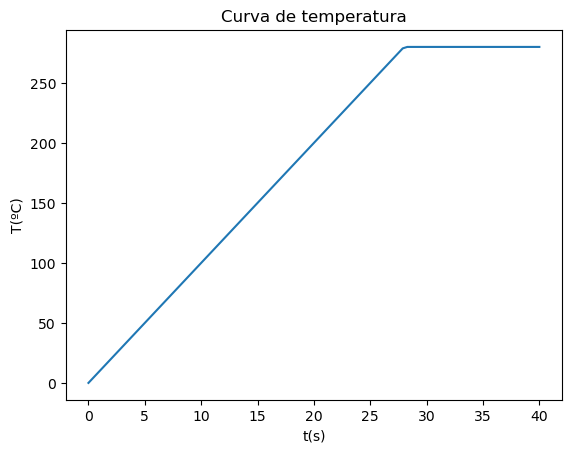

Se conserva la neutralidad de carga en el calentamiento


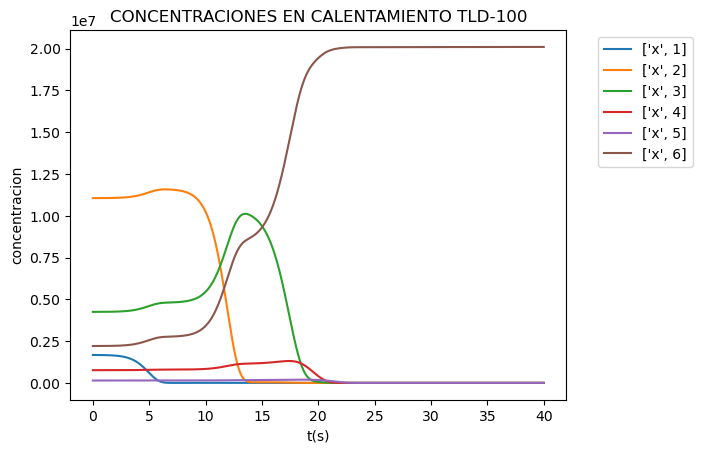

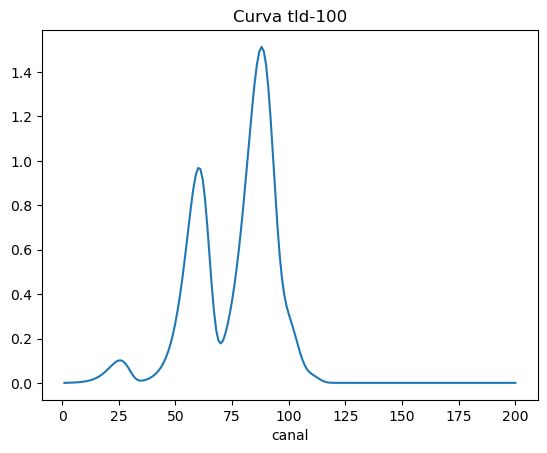

In [34]:
#En esta celda simulamos el calentamiento utilizando una curva de calentamiento que podemos definir

def CT(t):      #En esta función definimos la curva de calentamiento
    maxt=280
    beta=10
    if (beta*t+Tamb-273.15)<maxt:   #En este ejemplo hemos definido una rampa hasta los 250 grados seguido 
        T=Tamb+beta*t               #de un tiempo a temperatura constante
        tt=t
    else:
        T=maxt+273.15
    return(T)
t=np.linspace(0,40,100)     #En este vector incluimos el tiempo de calentamiento
T=np.zeros(len(t))          #Iniciamos un vector con las temperaturas
for i in range(len(t)):     #En este bucle llenamos el vector de temperaturas con nuestra curva de temperaturas
    T[i]=CT(t[i])

plt.plot(t,T-273.15)        #Representamos la curva de temperaturas
plt.title('Curva de temperatura')
plt.xlabel('t(s)')
plt.ylabel('T(ºC)')
plt.show()

mt=t[-1]   #Tiempo maximo de calentamiento
solcal=integ.solve_ivp(fun=TLECT,t_span=[0,mt],y0=xr[:,-1]) #Resolvemos el modelo para el calentamiento con nuestra curva de temperaturas
ttt=solcal.t
xxx=solcal.y
TTT=np.zeros(len(ttt)) #Aquí guardamos a qué temperatura corresponde cada instante de tiempo para representar la curva
for i in range(len(ttt)):     #En este bucle llenamos el vector de temperaturas con nuestra curva de temperaturas
    TTT[i]=CT(ttt[i])

pi=neutralidad(xx) #comprobamos si se cumple la neutralidad de carga
if pi.all() > 0.0001:
    print('No se conserva la neutralidad de carga en el calentamiento')
else:
    print('Se conserva la neutralidad de carga en el calentamiento')

for i in range(1,len(nn)-3):        #Representamos las concentraciones de electrones en las trampas durante el calentamiento
    plt.plot(ttt,xxx[i],label=['x',i])
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')    
plt.title('CONCENTRACIONES EN CALENTAMIENTO TLD-100')
plt.xlabel('t(s)')
plt.ylabel('concentracion')
plt.show()

temp,tlc=tl200(xxx,ttt,10)          #Simulamos la curva de termoluminiscencia en función de la simulación del calentamiento,
                                    #Nota: he puesto beta como '10' para usar la misma función que para el calentamiento lineal, pero no se que se suele usar

canal=np.linspace(1,200,200)        #Representamos la curva de termoluminiscencia
plt.plot(canal,tlc)
plt.title('Curva tld-100')
plt.xlabel('canal')
plt.show()